In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8c30b45e0b12d509a20f2161cd0d18056b3ffa72d46261e96a97bf35291e98ab
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.6 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # 최상의 하이퍼 파라미터를 선정해주는 라이브러리
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline



pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/model/4.11_obj_modi.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,fico_range_mean,target
0,1,680.82,126.0,277.0,0.0,0.0,110000.0,34.70,23200.000000,3,24.99,23200.0,2.0,0.0,2016,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,672.0,1
1,3,494.55,134.0,400.0,0.0,0.0,65000.0,17.74,16000.000000,7,7.07,16000.0,3.0,0.0,2017,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,822.0,1
2,4,146.10,226.0,130.0,2.0,2.0,50000.0,6.99,4500.000000,6,10.42,4500.0,1.0,0.0,2017,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,702.0,0
3,5,645.25,149.0,190.0,0.0,0.0,60000.0,28.94,20000.000000,6,9.99,20000.0,1.0,5.0,2015,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,677.0,0
4,6,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,737.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071205,1534129,662.45,232.0,144.0,0.0,0.0,60000.0,20.02,26450.000000,5,17.27,26500.0,1.0,0.0,2013,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,697.0,0
1071206,1534131,133.78,151.0,36.0,0.0,0.0,33800.0,19.18,3600.000000,3,19.99,3600.0,1.0,0.0,2014,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,667.0,1
1071207,1534132,583.89,125.0,216.0,0.0,0.0,71000.0,23.92,18875.000000,7,6.68,19000.0,5.0,0.0,2015,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,737.0,0
1071208,1534133,329.65,25.0,99.0,0.0,0.0,44000.0,12.85,9600.000000,5,14.33,9600.0,1.0,0.0,2013,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,692.0,0


In [ ]:
# 필요 없는 부분 제거
df.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
# X와 y를 나누기 위해 list 생성
x_data = list(df.columns)
x_data.remove('target')

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# Target

In [ ]:
df_train.describe()

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,fico_range_mean,target
count,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,6.427260e+05,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000,642726.000000
mean,434.761640,117.168640,173.710225,0.209494,0.132196,7.808290e+04,18.040965,14363.512210,5.313193,13.132939,14391.456818,1.551770,0.492904,2015.516279,6.496488,0.486265,0.000023,0.000114,0.110352,0.402554,0.223112,0.571460,0.000216,0.065330,0.006125,0.022691,0.011918,0.007045,0.060940,0.000681,0.011040,0.007355,0.001217,0.246376,0.012142,0.007392,0.024219,0.143492,0.021639,0.015271,0.002491,0.002839,0.071276,0.032266,0.004885,0.000011,0.001627,0.039155,0.016274,0.008254,0.009427,0.011485,0.023366,0.023554,0.001802,0.026202,0.017619,0.015825,0.005229,0.002858,0.027873,0.001363,0.003068,0.004854,0.036605,0.005349,0.014865,0.082838,0.032852,0.008960,0.012035,0.033803,0.004481,0.012144,0.002032,0.015209,0.081327,0.007177,0.028121,0.002069,0.021329,0.013066,0.003501,0.002108,699.212987,0.196623
std,262.880846,59.919806,99.882443,0.595254,0.373071,1.546321e+05,8.414966,8838.781854,1.269296,4.787585,8837.896521,1.936734,1.337002,1.834373,3.429807,0.499812,0.004831,0.010657,0.313328,0.490413,0.416333,0.494868,0.014704,0.247107,0.078025,0.148916,0.108517,0.083638,0.239221,0.026096,0.104492,0.085443,0.034860,0.430900,0.109520,0.085658,0.153728,0.350574,0.145502,0.122628,0.049847,0.053211,0.257286,0.176705,0.069725,0.003300,0.040309,0.193964,0.126529,0.090475,0.096634,0.106553,0.151063,0.151656,0.042408,0.159737,0.131561,0.124797,0.072125,0.053385,0.164610,0.036893,0.055306,0.069504,0.187790,0.072942,0.121012,0.275637,0.178250,0.094234,0.109041,0.180722,0.066790,0.109527,0.045032,

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [ ]:
prediction_times = []
training_times = []
scores = []


xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

NameError: name 'LinearSVC' is not defined

In [ ]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs = GridSearch(XGBClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:13:56
Prediction time: 
Execution Time: 00:00:01


In [ ]:
# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs = GridSearch(LGBMClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 126375, number of negative: 516351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 642726, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196623 -> initscore=-1.407533
[LightGBM] [Info] Start training from score -1.407533
Training time: 
Execution Time: 00:06:32
[LightGBM] [Warning] Accuracy may be bad since you didn't 

In [ ]:
# CatBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
cat_gs = GridSearch(CatBoostClassifier(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:00:12
Prediction time: 
Execution Time: 00:00:00


In [ ]:
# NgBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
ngb_gs = GridSearch(NGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[iter 0] loss=0.4789 val_loss=0.0000 scale=1.0000 norm=2.0000
Training time: 
Execution Time: 00:00:18
Prediction time: 
Execution Time: 00:00:01


In [ ]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearchEarlyStopping(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()

    if(type=='classification'): # 우리는 분류기만 쓰기에 이거만 작동함
        fit_params={
            "early_stopping_rounds":10,
            "eval_metric" : "auc",
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='accuracy', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    else:
        fit_params={
            "early_stopping_rounds":10,
            "eval_metric" : 'error',
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='r2', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [ ]:
# XGBoost with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs_es = GridSearchEarlyStopping(XGBClassifier(random_state=42), param_grid, X_train, y_train, X_test, y_test)

[0]	validation_0-auc:0.69087
[1]	validation_0-auc:0.70219
[2]	validation_0-auc:0.70574
[3]	validation_0-auc:0.70711
[4]	validation_0-auc:0.70745
[5]	validation_0-auc:0.70770
[6]	validation_0-auc:0.70795
[7]	validation_0-auc:0.70849
[8]	validation_0-auc:0.70889
[9]	validation_0-auc:0.70909
[10]	validation_0-auc:0.70937
[11]	validation_0-auc:0.70962
[12]	validation_0-auc:0.70990
[13]	validation_0-auc:0.70996
[14]	validation_0-auc:0.71014
[15]	validation_0-auc:0.71021
[16]	validation_0-auc:0.71037
[17]	validation_0-auc:0.71053
[18]	validation_0-auc:0.71065
[19]	validation_0-auc:0.71071
[20]	validation_0-auc:0.71082
[21]	validation_0-auc:0.71097
[22]	validation_0-auc:0.71114
[23]	validation_0-auc:0.71131
[24]	validation_0-auc:0.71146
[25]	validation_0-auc:0.71157
[26]	validation_0-auc:0.71168
[27]	validation_0-auc:0.71178
[28]	validation_0-auc:0.71192
[29]	validation_0-auc:0.71204
[30]	validation_0-auc:0.71214
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.71239
[33]	validation_0-au

In [ ]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearchEarlyStopping(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()

    if(type=='classification'): # 우리는 분류기만 쓰기에 이거만 작동함
        fit_params={
            # "early_stopping_rounds":10,
            "eval_metric" : "auc",
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='accuracy', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    else:
        fit_params={
            # "early_stopping_rounds":10,
            "eval_metric" : 'error',
            "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='r2', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [ ]:
# LightGBM with GridSearch with Early Stopping
param_grid=[{'max_depth':[5,10],
             'num_leaves' : [50,100],
             'n_estimators':[100],
             'learning_rate':[0.05,0.1],
             'colsample_bytree':[0.8,0.95]}]
lgb_gs_es = GridSearchEarlyStopping(LGBMClassifier(early_stopping_rounds=10, random_state=42), param_grid,X_train[:4000], y_train[:4000], X_test, y_test)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 740, number of negative: 3260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 66
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185000 -> initscore=-1.482832
[LightGBM] [Info] Start training from score -1.482832
[LightGBM] [Warnin

In [ ]:
def GridSearchEarlyStopping_cat_ngb(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()

    if(type=='classification'):
        fit_params={
            "early_stopping_rounds":10,
            # "eval_metric" : "auc",
            # "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='accuracy', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    else:
        fit_params={
            "early_stopping_rounds":10,
            # "eval_metric" : "error",
            # "eval_set" : [[X_predict, y_predict]]
        }
        model = GridSearchCV(
            clf, params, scoring='r2', n_jobs=-1, cv=5
        ).fit(X,y, **fit_params).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [ ]:
# CatBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}] # rsm(response surface methodology) 반응 표면 분석법
cat_gs_es = GridSearchEarlyStopping_cat_ngb(CatBoostClassifier(random_state=42, silent = False,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

0:	learn: 0.6660193	total: 9.32ms	remaining: 923ms
1:	learn: 0.6429001	total: 14.9ms	remaining: 730ms
2:	learn: 0.6205276	total: 20.2ms	remaining: 653ms
3:	learn: 0.5993618	total: 25.3ms	remaining: 608ms
4:	learn: 0.5811986	total: 32ms	remaining: 609ms
5:	learn: 0.5655854	total: 37.8ms	remaining: 593ms
6:	learn: 0.5518771	total: 47.4ms	remaining: 630ms
7:	learn: 0.5402923	total: 54.7ms	remaining: 629ms
8:	learn: 0.5278955	total: 64ms	remaining: 647ms
9:	learn: 0.5189931	total: 70.6ms	remaining: 635ms
10:	learn: 0.5118474	total: 77.2ms	remaining: 625ms
11:	learn: 0.5039958	total: 85.5ms	remaining: 627ms
12:	learn: 0.4973773	total: 90.9ms	remaining: 608ms
13:	learn: 0.4925956	total: 95.6ms	remaining: 587ms
14:	learn: 0.4862051	total: 105ms	remaining: 592ms
15:	learn: 0.4806013	total: 113ms	remaining: 592ms
16:	learn: 0.4755054	total: 119ms	remaining: 583ms
17:	learn: 0.4711925	total: 127ms	remaining: 579ms
18:	learn: 0.4666246	total: 130ms	remaining: 554ms
19:	learn: 0.4633841	total: 133

In [ ]:
# NgBoost with GridSearch with Early Stopping
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1]}]
ngb_gs_es = GridSearchEarlyStopping_cat_ngb(NGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[iter 0] loss=0.4789 val_loss=0.0000 scale=1.0000 norm=2.0000
Training time: 
Execution Time: 00:00:19
Prediction time: 
Execution Time: 00:00:01


In [ ]:
models = [
    ('XGBoost GridSearch', xgboost_gs),
    ('LightGBM GridSearch', lgb_gs),
    ('CatBoost GridSearch', cat_gs),
    ('NgBoost GridSearch', ngb_gs),
    ('XGBoost GS EarlyStopping', xgboost_gs_es),
    ('LightGBM GS EarlyStopping', lgb_gs_es),
    ('CatBoost GS EarlyStopping', cat_gs_es),
    ('NgBoost GS EarlyStopping', ngb_gs_es)
]

In [ ]:
# score에 있는 점수를 소수점 5째자리까지 반올림
for i in range(len(scores)):
    scores[i] = round(scores[i],5)
scores

[0.80748, 0.80749, 0.8046, 0.80387, 0.80749, 0.8046, 0.80387, 0.80308]

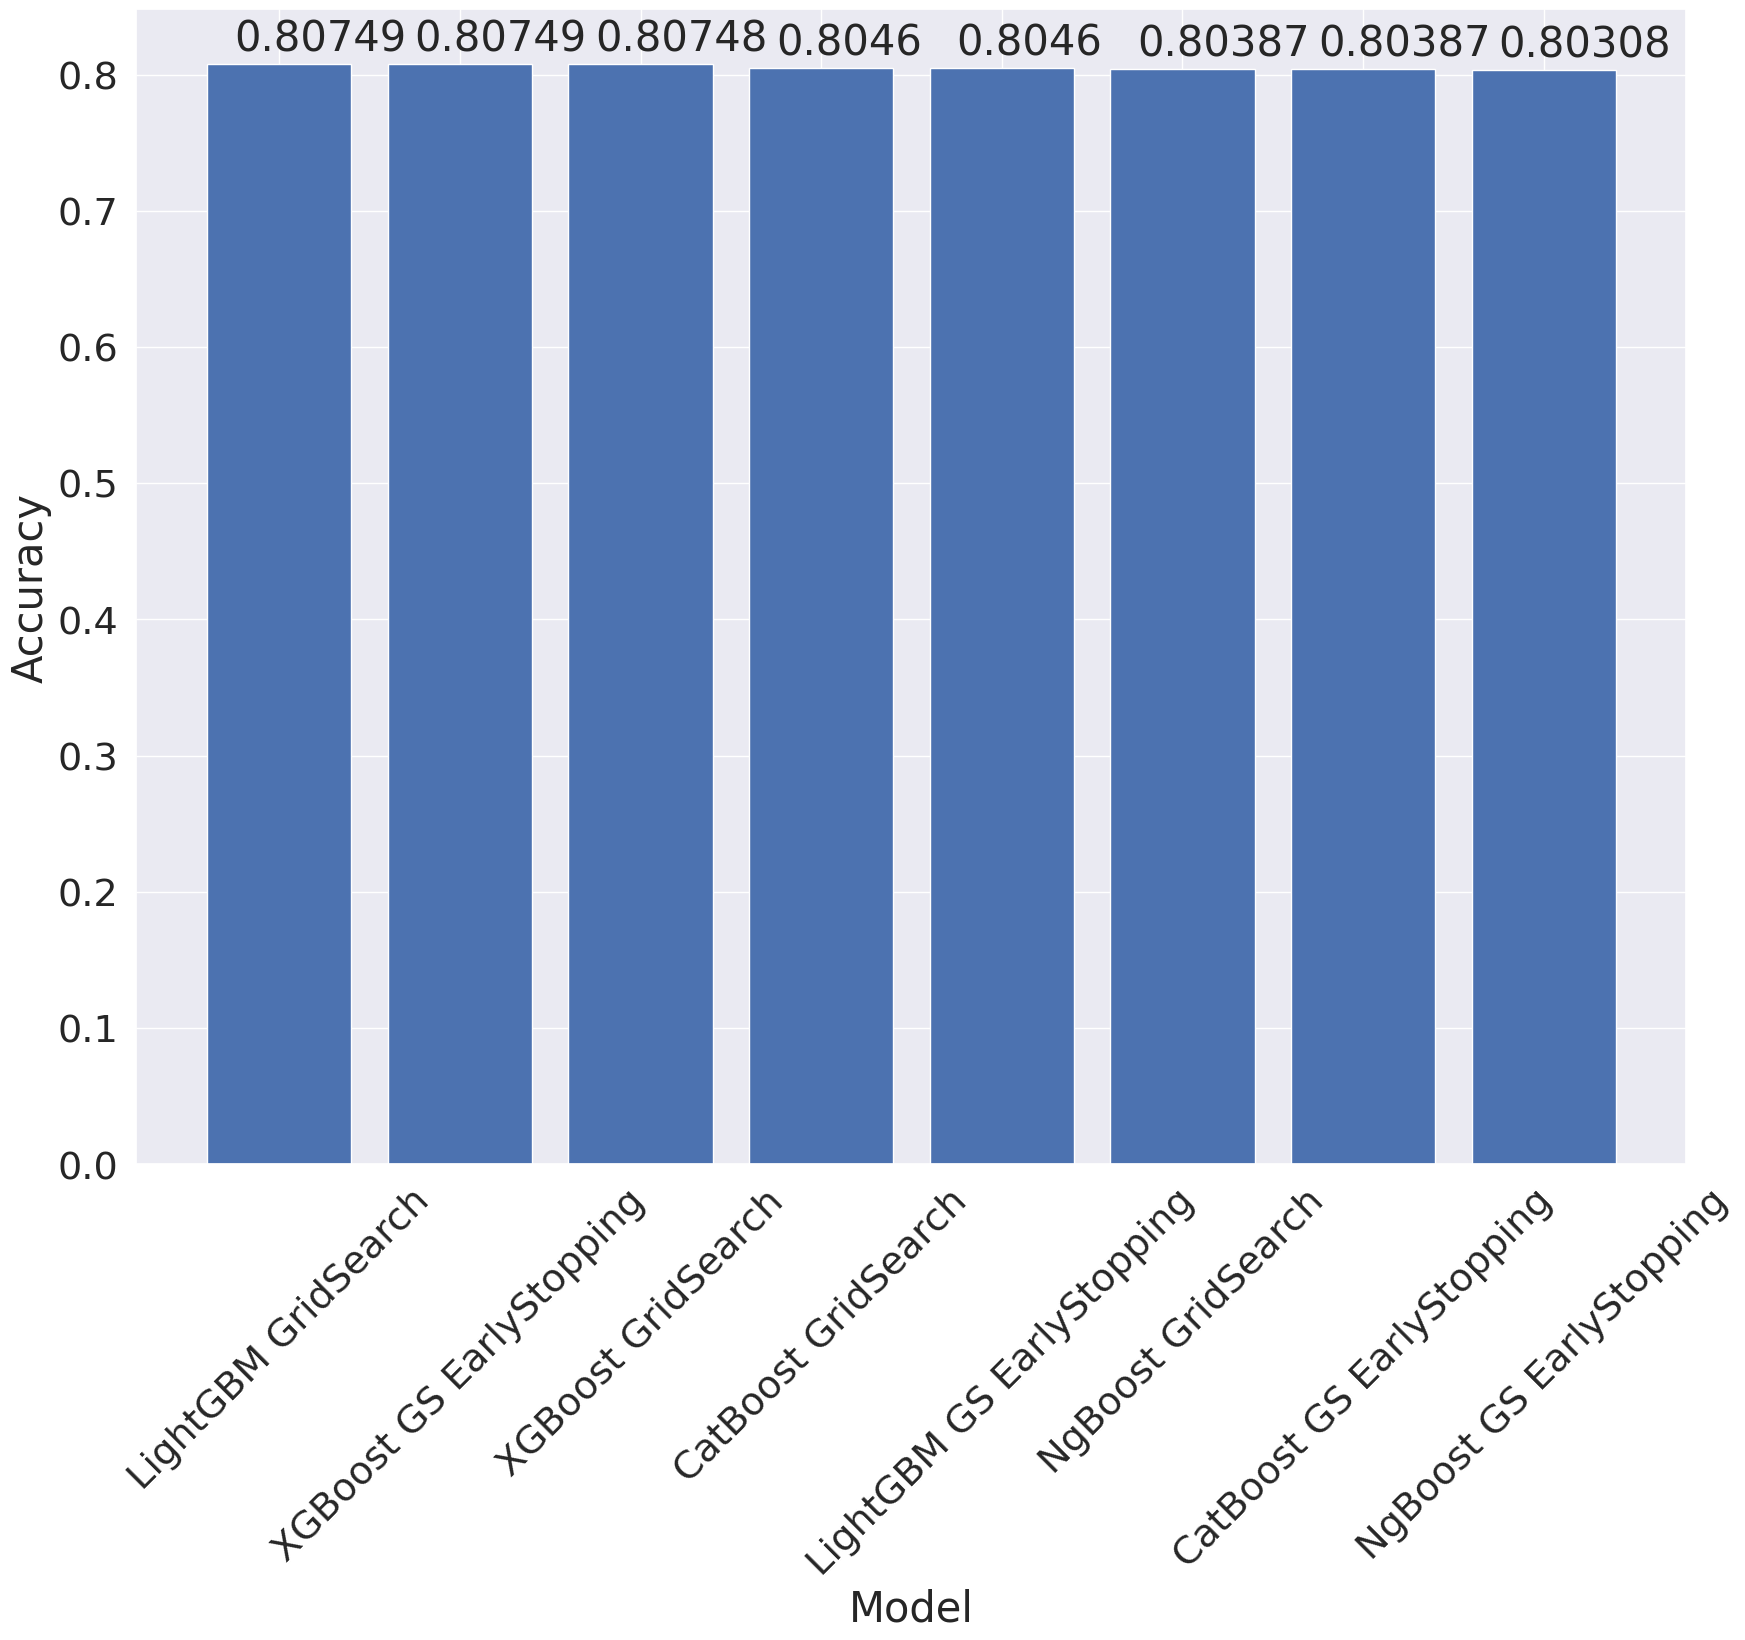

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')